## ML modelling using Light GBM

Not the best model score on Kaggle (2.39, better than SARIMA, worse than naive methods). Did not come in top 5 models overall. Would require more time for feature engineering and other ways to cope with the size of the dataset (here we limited it to the last 6 months of the train.csv)

NOTE: Due to the .csv file size (850mb for 6 months training data), please run ```ml_data_structuring.ipynb``` first to obtain the required .csv (```long_train_6_mths_with_lags.csv```) before running this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# import datetime module
import datetime as dt

In [2]:
df_sub = pd.read_csv("../datasets/sample_submission.csv")
df_long_train = pd.read_csv("../datasets/long_train_6_mths_with_lags.csv")
df_long_train.head()

,date,id,subcat_id,category_id,store_id,region_id,d,units_sold,wm_yr_wk,weekday,...,year,sell_price,item_id,units_sold_l7,units_sold_l14,units_sold_l21,day_of_month,day_of_year,week_of_month,week_of_year
0,2015-10-30,Beauty_1_001_East_1,Beauty_1,Beauty,East_1,East,d_1736,2,11539.0,Friday,...,2015.0,8.26,Beauty_1_001,0,0,0,30.0,303.0,5.0,43.0
1,2015-10-30,Beauty_1_002_East_1,Beauty_1,Beauty,East_1,East,d_1736,1,11539.0,Friday,...,2015.0,3.97,Beauty_1_002,0,0,0,30.0,303.0,5.0,43.0
2,2015-10-30,Beauty_1_003_East_1,Beauty_1,Beauty,East_1,East,d_1736,0,11539.0,Friday,...,2015.0,2.97,Beauty_1_003,0,0,0,30.0,303.0,5.0,43.0
3,2015-10-30,Beauty_1_004_East_1,Beauty_1,Beauty,East_1,East,d_1736,0,11539.0,Friday,...,2015.0,4.64,Beauty_1_004,0,0,0,30.0,303.0,5.0,43.0
4,2015-10-30,Beauty_1_005_East_1,Beauty_1,Beauty,East_1,East,d_1736,1,11539.0,Friday,...,2015.0,2.88,Beauty_1_005,0,0,0,30.0,303.0,5.0,43.0


Ensure that dtypes are consistent before training model

In [3]:
print(df_long_train.dtypes)

date               object
id                 object
subcat_id          object
category_id        object
store_id           object
region_id          object
d                  object
units_sold          int64
wm_yr_wk          float64
weekday            object
wday              float64
month             float64
year              float64
sell_price        float64
item_id            object
units_sold_l7       int64
units_sold_l14      int64
units_sold_l21      int64
day_of_month      float64
day_of_year       float64
week_of_month     float64
week_of_year      float64
dtype: object


In [4]:
df_long_train["date"] = pd.to_datetime(df_long_train["date"])
categorical_features = ["category_id", "store_id", "region_id", "weekday", "wday", "month", "year", "day_of_month", "day_of_year", "week_of_month", "week_of_year"]
string_features = ["id", "subcat_id", "d", "item_id"]

for f in categorical_features :
    df_long_train[f] = df_long_train[f].astype("category")

for f in string_features :
    df_long_train[f] = df_long_train[f].astype("string")

In [5]:
# Sort dataframe by date, retain original index so items are in order
df_long_train = df_long_train.rename_axis("idx")
df_long_train = df_long_train.sort_values(by = ["idx", "date"])
df_long_train["idx"] = df_long_train.index
df_long_train = df_long_train.set_index("date")
df_long_train.head()

,id,subcat_id,category_id,store_id,region_id,d,units_sold,wm_yr_wk,weekday,wday,...,sell_price,item_id,units_sold_l7,units_sold_l14,units_sold_l21,day_of_month,day_of_year,week_of_month,week_of_year,idx
date,,,,,,,,,,,,,,,,,,,,,
2015-10-30,Beauty_1_001_East_1,Beauty_1,Beauty,East_1,East,d_1736,2,11539.0,Friday,7.0,...,8.26,Beauty_1_001,0,0,0,30.0,303.0,5.0,43.0,0
2015-10-30,Beauty_1_002_East_1,Beauty_1,Beauty,East_1,East,d_1736,1,11539.0,Friday,7.0,...,3.97,Beauty_1_002,0,0,0,30.0,303.0,5.0,43.0,1
2015-10-30,Beauty_1_003_East_1,Beauty_1,Beauty,East_1,East,d_1736,0,11539.0,Friday,7.0,...,2.97,Beauty_1_003,0,0,0,30.0,303.0,5.0,43.0,2
2015-10-30,Beauty_1_004_East_1,Beauty_1,Beauty,East_1,East,d_1736,0,11539.0,Friday,7.0,...,4.64,Beauty_1_004,0,0,0,30.0,303.0,5.0,43.0,3
2015-10-30,Beauty_1_005_East_1,Beauty_1,Beauty,East_1,East,d_1736,1,11539.0,Friday,7.0,...,2.88,Beauty_1_005,0,0,0,30.0,303.0,5.0,43.0,4


 # Correlation of price on sales

In [12]:
corr = df_long_train[['sell_price', 'units_sold']].corr()
print('Correlation between sales and price:', corr.iloc[0,1])

Correlation between sales and price: -0.1312463936768341


There is a slight negative correlation between units sold and price, which is not surprising, given the basic concept that people buy less items if the price is higher.
However, -0.13 is a small negative correlation only, so we cannot conclude that there is a strong negative correlation. This is also seen in the scatter plot below with no strong linear correlation between the features.

Another explanation for this slight negative correlation could also be that the cheaper products tend to be the more essential goods (like food), which people would buy even if prices were high. So the demand of the products is not necessarily based on price alone.

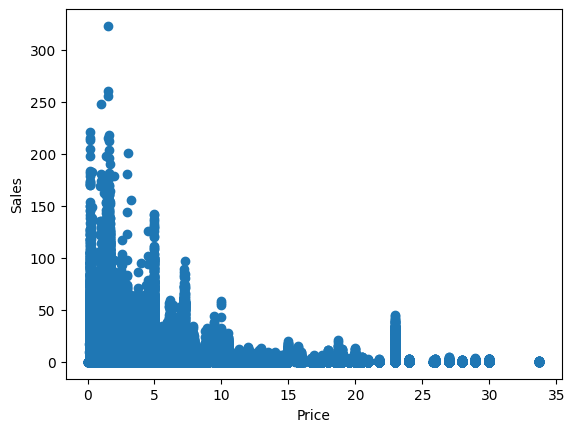

In [13]:
plt.scatter(df_long_train['sell_price'], df_long_train['units_sold'])
plt.xlabel('Price')
plt.ylabel('Sales')
plt.show()

 ### Fit LGBM

Using all possible features, including price and lags

First we do a 80/20 test split and look at the rmse on 20% of the test data.

Then use the entire train dataset to predict for the subsequent 21 days. 

In [6]:
end_train_date = "2016-04-30"
lagged_features = ["units_sold_l7", "units_sold_l14", "units_sold_l21"]

# Select training set until before forecast date 
X_subset = df_long_train.loc[:end_train_date][["category_id", "store_id", "region_id", "wday", "month", "year", "day_of_month", "day_of_year", "week_of_month", "week_of_year", "sell_price"] + lagged_features].dropna()

X_subset = pd.get_dummies(X_subset)
y = df_long_train.loc[:end_train_date]['units_sold'].dropna().values

In [20]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size = 0.2)

# LGBM dataset
train_data_80 = lgb.Dataset(X_train, label = y_train, free_raw_data = True)
params = {'objective': 'regression', 'metric': 'rmse'}

In [21]:
# Fit LGBM
lgb_model_80 = lgb.train(params, train_data_80)

# Test
pred = lgb_model_80.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 4486365, number of used features: 206
[LightGBM] [Info] Start training from score 1.282746


In [17]:
print(np.sqrt(mean_squared_error(y_test, pred.round().astype(int))))

2.3016646005403154


### Forecast for the next 21 days, using the entire train dataset (best model for ML, obtained Kaggle score = 2.39)

NOTE: Ran into memory error when training for 1 year of training data, the error was that it required 35.2 Gb of space. So we stick to 6 months training data.

In [7]:
fc_days_dr = pd.date_range(start = "2016-05-01", end = "2016-05-21")
fc_days_idx = df_long_train.loc[fc_days_dr]["idx"]

train_data = lgb.Dataset(X_subset, label = y, free_raw_data = True)
params = {'objective': 'regression', 'metric': 'rmse'}
lgb_model = lgb.train(params, train_data)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 5607957, number of used features: 284
[LightGBM] [Info] Start training from score 1.303665


In [9]:
# Predict using the features already created from the last 21 days of the df
x_fc_subset = X_subset.iloc[-len(fc_days_idx):, :]
fc = lgb_model.predict(x_fc_subset).round().astype(int)

In [10]:
df_preds = pd.DataFrame(
    {"date" : df_long_train.index[fc_days_idx],
     "y" : fc,
     "id" : df_long_train.loc[fc_days_dr]["id"]}
)

df_preds = df_preds.reset_index(drop = True)

fc_dr = pd.date_range(start = "2016-05-01", periods = 21)
date_to_d_dict_fc = dict(zip(list(fc_dr), list(df_sub.columns[1:])))

df_preds = df_preds.pivot(index = "id", columns = "date", values = "y").reset_index().rename(date_to_d_dict_fc, axis = 1)
df_preds.head()

,date,y,id
0,2016-05-01,1,Beauty_1_001_East_1
1,2016-05-01,0,Beauty_1_002_East_1
2,2016-05-01,0,Beauty_1_003_East_1
3,2016-05-01,2,Beauty_1_004_East_1
4,2016-05-01,2,Beauty_1_005_East_1


In [28]:
# df_preds.to_csv("../submissions/ml_preds/6_mths_train_with_lags.csv", index = False)

In [14]:
# Export model used for forecast
# lgb_model.save_model("../submissions/ml_best_models_params/lgb_model_fc.txt", num_iteration=lgb_model.best_iteration)

### Looking at the best features for the model

The lagged features performed the best, starting from lag 7, 14 and 21. The importance of the features is confirmed by the seasonality of a week as mentioned in the EDA. So the day one week ago would be the best indicator of how many items would be sold for the same day in the upcoming week. Previous weeks gets less important for forecasting.

Also, though there was not a strong correlation with price, price was the second most important feature, suggesting that there is some relation to demand and supply.

There seems like product category (food and beauty) were also relatively strong predictors. Maybe these product categories have distinct trends compared to cleaning.

The east region (along with a few other stores in the east) also seemed to be relatively important.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

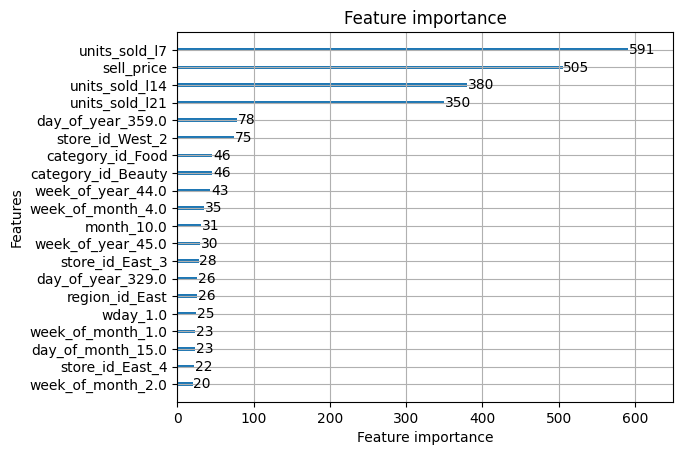

In [13]:
lgb.plot_importance(lgb_model, max_num_features=20)

### Evaluation of ML model
Overall, model did provide decent performance (better than ARIMA), but not as good as naive methods. Perhaps because we were limited by the feature engineering that only used lags by items sold. Also the preparation of data was time intensive (took about 2 afternoons to prepare), and we ran into frequent memory issues. While there is untapped potential for the ML method, naive methods are still the most time and computationally effective methods of forecasting for this dataset (and it can be run on all items for all days, instead of ML which could be run only on the last 6 months of train data). 

### Future work
Creating more lag features, such as price lagged (but we have to first check if there is seasonality for price). 

Hyperparameter tuning for lgbm, and trying xgboost.

We could also try other more creative ways of choosing the train data (other than the last 6 months prior to forecast, as what we have done here). Maybe we could have 10 different models by each store, and then use them to build some ensemble model to predict each item.